In [ ]:
pip install cassandra-driver


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 24.4 MB/s eta 0:00:00


In [12]:
import requests
import pandas as pd

# Polygon.io API URL for getting stock data (example: AAPL)
url = "https://api.polygon.io/v2/aggs/ticker/AAPL/prev"

# Your API Key
api_key = "ly1vbw8ONU_RUUK7FDWq3FvP6coM_0qh"

# Adding API key to query parameters
params = {
    'apiKey': api_key  # Include your API key in the parameters
}

# Make the GET request to fetch data
response = requests.get(url, params=params)

# Check if the request was successful
if response.status_code == 200:
    data = response.json()  # Convert response to JSON

    # Extract the results and create a DataFrame
    results = data.get('results', [])
    if results:
        df = pd.DataFrame(results)

        # Specify the file path
        file_path = r"C:\Users\ruthv\Desktop\Parking_Violations_Issued_.csv"

        # Save the DataFrame to CSV
        df.to_csv(file_path, index=False)  # Save without the index column

        print(f"Data saved successfully to {file_path}")
    else:
        print("No data found in the response.")
else:
    print(f"Failed to retrieve data: {response.status_code}")


Data saved successfully to C:\Users\ruthv\Desktop\Parking_Violations_Issued_.csv


In [ ]:
!pip install pyyaml


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving credentials.yml to credentials.yml


In [ ]:
import yaml

# Load credentials from the uploaded file
with open('credentials.yml', 'r') as file:
    credentials = yaml.safe_load(file)

# Extract values securely
client_id = credentials['clientId']
client_secret = credentials['secret']


In [ ]:
import yaml

# Load the YAML file
with open('credentials.yml', 'r') as file:
    credentials = yaml.safe_load(file)

# Extract clientId and clientSecret securely from the dictionary
client_id = credentials['clientId']
client_secret = credentials['secret']

# Print them (for testing purposes, avoid in production)
print("Client ID and Secret are loaded securely.")


Client ID and Secret are loaded securely.


In [ ]:
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Path to your secure connect bundle
SECURE_CONNECT_BUNDLE = '/content/secure-connect-my-first-app.zip'  # Adjust path if needed
KEYSPACE = 'traffic'  # Your keyspace
DATABASE = 'my_first_app'  # Your database name

# Setup the connection to Astra DB using credentials from the YAML file
auth_provider = PlainTextAuthProvider(client_id, client_secret)
cluster = Cluster(cloud={'secure_connect_bundle': SECURE_CONNECT_BUNDLE}, auth_provider=auth_provider)
session = cluster.connect(KEYSPACE)

print("Connected to Astra DB successfully!")


Connected to Astra DB successfully!


In [ ]:
import pandas as pd
import logging
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider
from cassandra.concurrent import execute_concurrent_with_args
from typing import List, Tuple
import yaml
from functools import wraps

# 1. Logging Setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 2. Decorator for Error Handling
def error_handler(func):
    """Decorator to handle errors gracefully"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            logger.error(f"Error in {func.__name__}: {e}")
            return None
    return wrapper

# 3. DataFrame Transformation - Functional Approach
@error_handler
def transform_data(df: pd.DataFrame) -> List[Tuple]:
    """Transform the CSV data into tuples for bulk insert"""
    required_columns = ['Summons Number', 'Plate ID', 'Registration State', 'Plate Type',
                        'Issue Date', 'Violation Code', 'Vehicle Body Type', 'Vehicle Make', 'Issuing Agency']
    df_cleaned = df[required_columns].fillna('N/A')

    def safe_int(value: str) -> int:
        """Convert value to integer or return 0 if not possible"""
        try:
            return int(float(value))  # Handle float/int values from CSV
        except (ValueError, TypeError):
            return 0

    df_cleaned['Violation Code'] = df_cleaned['Violation Code'].apply(safe_int)
    logger.info("Data cleaned and 'violation_code' converted to integers.")
    return [
        (
            str(row['Summons Number']),
            str(row['Plate ID']),
            str(row['Registration State']),
            str(row['Plate Type']),
            str(row['Issue Date']),
            row['Violation Code'],  # Keep as integer
            str(row['Vehicle Body Type']),
            str(row['Vehicle Make']),
            str(row['Issuing Agency']),
        )
        for _, row in df_cleaned.iterrows()
    ]

# 4. Database Connection Class
class AstraDBConnection:
    """Class to manage the connection to Astra DB and insert data"""
    def __init__(self, bundle_path: str, client_id: str, client_secret: str, keyspace: str):
        self.bundle_path = bundle_path
        self.client_id = client_id
        self.client_secret = client_secret
        self.keyspace = keyspace
        self.session = None

    @error_handler
    def connect(self) -> None:
        """Connect to Astra DB"""
        auth_provider = PlainTextAuthProvider(self.client_id, self.client_secret)
        cluster = Cluster(cloud={'secure_connect_bundle': self.bundle_path}, auth_provider=auth_provider)
        self.session = cluster.connect(self.keyspace)
        logger.info("Connected to Astra DB successfully!")

    @error_handler
    def create_table(self) -> None:
        """Create the table if it doesn't exist"""
        create_table_query = """
        CREATE TABLE IF NOT EXISTS parking_violations (
            summons_number TEXT PRIMARY KEY,
            plate_id TEXT,
            registration_state TEXT,
            plate_type TEXT,
            issue_date TEXT,
            violation_code INT,
            vehicle_body_type TEXT,
            vehicle_make TEXT,
            issuing_agency TEXT
        );
        """
        self.session.execute(create_table_query)
        logger.info("Table 'parking_violations' created successfully.")

    @error_handler
    def bulk_insert_data(self, data: List[Tuple]) -> None:
        """Insert data in bulk into the table"""
        insert_query = """
        INSERT INTO parking_violations (
            summons_number, plate_id, registration_state, plate_type, issue_date,
            violation_code, vehicle_body_type, vehicle_make, issuing_agency
        ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
        """
        prepared = self.session.prepare(insert_query)
        execute_concurrent_with_args(self.session, prepared, data, concurrency=50)
        logger.info("Bulk data inserted successfully into Astra DB.")

    @error_handler
    def count_rows(self) -> int:
        """Count the number of rows in the table"""
        count_query = "SELECT COUNT(*) FROM parking_violations;"
        result = self.session.execute(count_query)
        for row in result:
            return row[0]
        return 0

# 5. Function to load CSV data securely
@error_handler
def load_csv(file_path: str) -> pd.DataFrame:
    """Load the CSV file into a DataFrame"""
    df = pd.read_csv(file_path)
    logger.info(f"Loaded CSV file: {file_path} with {len(df)} rows and {len(df.columns)} columns.")
    return df

# 6. Main Function
@error_handler
def main():
    """Main function to load data, insert into DB, and count rows"""
    # Load credentials from YAML file
    with open('credentials.yml', 'r') as file:
        credentials = yaml.safe_load(file)

    client_id = credentials['clientId']
    client_secret = credentials['secret']
    secure_connect_bundle = '/content/secure-connect-my-first-app.zip'  # Adjust path
    keyspace = 'traffic'
    csv_file_path = '/content/Parking_Violations_Issued.csv'

    # Load CSV data
    df = load_csv(csv_file_path)
    if df is None:
        return

    # Transform Data
    data = transform_data(df)
    if not data:
        return

    # Connect to Astra DB and insert data
    db = AstraDBConnection(secure_connect_bundle, client_id, client_secret, keyspace)
    db.connect()
    db.create_table()
    db.bulk_insert_data(data)

    # Display the number of rows
    row_count = db.count_rows()
    logger.info(f"Total rows in table: {row_count}")
    print(f"Total rows in table: {row_count}")

# Run the main function
if __name__ == "__main__":
    main()


Total rows in table: 99999


In [ ]:
import pandas as pd
import logging
from cassandra.cluster import Cluster
from cassandra.concurrent import execute_concurrent_with_args
from cassandra.auth import PlainTextAuthProvider
import yaml
from functools import wraps
from typing import List, Tuple

# 1. Logging Setup
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

# 2. Decorator for Error Handling
def error_handler(func):
    """Decorator to handle errors gracefully"""
    @wraps(func)
    def wrapper(*args, **kwargs):
        try:
            return func(*args, **kwargs)
        except Exception as e:
            logger.error(f"Error in {func.__name__}: {e}")
            return None
    return wrapper

# 3. Load and Clean Data (Silver Layer)
@error_handler
def load_and_clean_data(file_path: str) -> pd.DataFrame:
    """Load CSV and clean the data (remove duplicates, handle missing values)"""
    # Load the CSV file into a DataFrame
    df = pd.read_csv(file_path)
    logger.info(f"Loaded CSV file: {file_path} with {len(df)} rows and {len(df.columns)} columns.")

    # Remove duplicates
    df_cleaned = df.drop_duplicates()
    logger.info(f"Removed {len(df) - len(df_cleaned)} duplicate rows.")

    # Fill missing values with 'N/A' for strings and 0 for numerical columns
    df_cleaned = df_cleaned.fillna({
        'Summons Number': 'N/A',
        'Plate ID': 'N/A',
        'Registration State': 'N/A',
        'Plate Type': 'N/A',
        'Issue Date': 'N/A',
        'Violation Code': 0,
        'Vehicle Body Type': 'N/A',
        'Vehicle Make': 'N/A',
        'Issuing Agency': 'N/A'
    })

    # Ensure the 'Violation Code' column is of integer type
    df_cleaned['Violation Code'] = df_cleaned['Violation Code'].apply(lambda x: int(x) if str(x).isdigit() else 0)

    logger.info("Data cleaned successfully.")
    return df_cleaned

# 4. Function to insert data into Astra DB
@error_handler
def insert_data_to_db(session, data: List[Tuple]) -> None:
    """Insert cleaned data into the parking_violations table in Astra DB"""
    # Prepare the insert query
    insert_query = """
    INSERT INTO parking_violations (
        summons_number, plate_id, registration_state, plate_type, issue_date, violation_code,
        vehicle_body_type, vehicle_make, issuing_agency
    ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?);
    """
    prepared = session.prepare(insert_query)
    execute_concurrent_with_args(session, prepared, data, concurrency=50)
    logger.info("Data inserted successfully into Astra DB.")

# 5. Main function to load, clean and insert data
@error_handler
def main():
    # Load credentials from YAML file (assumed to be uploaded)
    with open('/content/credentials.yml', 'r') as file:
        credentials = yaml.safe_load(file)

    client_id = credentials['clientId']
    client_secret = credentials['secret']
    secure_connect_bundle = '/content/secure-connect-my-first-app.zip'  # Adjust path if necessary
    keyspace = 'traffic'
    csv_file_path = '/content/Parking_Violations_Issued.csv'  # Path to your uploaded file

    # Connect to Astra DB
    auth_provider = PlainTextAuthProvider(client_id, client_secret)
    cluster = Cluster(cloud={'secure_connect_bundle': secure_connect_bundle}, auth_provider=auth_provider)
    session = cluster.connect(keyspace)
    logger.info("Connected to Astra DB successfully!")

    # Load and clean the data
    df_cleaned = load_and_clean_data(csv_file_path)
    if df_cleaned is None:
        logger.error("Data cleaning failed.")
        return

    # Prepare the data for insertion
    data_to_insert = [
        (
            str(row['Summons Number']),
            str(row['Plate ID']),
            str(row['Registration State']),
            str(row['Plate Type']),
            str(row['Issue Date']),
            row['Violation Code'],  # Keep as integer
            str(row['Vehicle Body Type']),
            str(row['Vehicle Make']),
            str(row['Issuing Agency'])
        )
        for _, row in df_cleaned.iterrows()
    ]

    # Insert cleaned data into Astra DB
    insert_data_to_db(session, data_to_insert)

    # Verify the number of rows in the table
    count_query = "SELECT COUNT(*) FROM parking_violations;"
    rows = session.execute(count_query)
    for row in rows:
        logger.info(f"Total rows in table: {row[0]}")
        print(f"Total rows in table: {row[0]}")

# Run the main function
if __name__ == "__main__":
    main()


Total rows in table: 99999


In [ ]:
import pandas as pd

# Example:  df_cleaned is already cleaned data
df_cleaned = pd.read_csv('/content/Parking_Violations_Issued.csv')

# Clean the data (example of basic cleaning)
df_cleaned = df_cleaned.drop_duplicates()  # Remove duplicates
df_cleaned = df_cleaned.fillna('N/A')  # Fill missing values

# Display the cleaned data (first 10 rows)
print("Displaying the cleaned data (first 10 rows):")
print(df_cleaned.head(10))


Displaying the cleaned data (first 10 rows):
   Summons Number Plate ID Registration State Plate Type  Issue Date  \
0      1361929741  FCJ5493                 NY        PAS  12/18/1970   
1      1366962000  63540MC                 NY        COM    2/2/1971   
2      1342296187  GCY4187                 NY        SRF   9/18/1971   
3      1342296199  95V6675                 TX        PAS   9/18/1971   
4      1342296217  FYM5117                 NY        SRF   9/18/1971   
5      1356906515  GFM1421                 NY        PAS   9/18/1971   
6      1337077380  18972BB                 NY        999  10/10/1971   
7      1364523796  WNJ4730                 VA        PAS    4/5/1973   
8      1359914924  68091JZ                 NY        COM   7/22/1973   
9      1355498326  EWV4127                 NY        PAS   8/12/1973   

   Violation Code Vehicle Body Type Vehicle Make Issuing Agency  
0              20              SUBN          GMC              S  
1              46             

In [ ]:
@error_handler
def aggregate_data(df: pd.DataFrame):
    """Aggregate the data by Registration State, Vehicle Make, and Violation Code."""
    # Aggregation by Registration State
    agg_by_state = df.groupby('Registration State').size().reset_index(name='Count')

    # Aggregation by Vehicle Make
    agg_by_make = df.groupby('Vehicle Make').size().reset_index(name='Count')

    # Aggregation by Violation Code
    agg_by_violation = df.groupby('Violation Code').size().reset_index(name='Count')

    return agg_by_state, agg_by_make, agg_by_violation


In [ ]:
from cassandra.concurrent import execute_concurrent_with_args

def insert_aggregated_data(table_name: str, data: pd.DataFrame):
    if table_name == 'aggregated_by_registration_state':
        insert_query = """
        INSERT INTO aggregated_by_registration_state (registration_state, count)
        VALUES (?, ?);
        """
    elif table_name == 'aggregated_by_vehicle_make':
        insert_query = """
        INSERT INTO aggregated_by_vehicle_make (vehicle_make, count)
        VALUES (?, ?);
        """
    elif table_name == 'aggregated_by_violation_code':
        insert_query = """
        INSERT INTO aggregated_by_violation_code (violation_code, count)
        VALUES (?, ?);
        """
    else:
        logger.error(f"Unknown table name: {table_name}")
        return

    prepared = session.prepare(insert_query)
    execute_concurrent_with_args(session, prepared, data.values.tolist(), concurrency=50)
    print(f"Aggregated data inserted into {table_name}.")


In [ ]:
# Before inserting, print the aggregated data
print("Aggregated by Registration State:")
print(agg_by_state.head())

print("Aggregated by Vehicle Make:")
print(agg_by_make.head())

print("Aggregated by Violation Code:")
print(agg_by_violation.head())


Aggregated by Registration State:
  Registration State  Count
0                 99   1992
1                 AB      1
2                 AK      9
3                 AL     92
4                 AR     19
Aggregated by Vehicle Make:
  Vehicle Make  Count
0        31SRI      1
1        41120      1
2           4R      1
3           AC      1
4        ACURA   1555
Aggregated by Violation Code:
   Violation Code  Count
0               1      2
1               3      1
2               4      6
3               5   3462
4               6     10


In [ ]:
# Example: Data format before insertion
print("Data to be inserted into 'aggregated_by_registration_state':")
print(agg_by_state.values.tolist())


Data to be inserted into 'aggregated_by_registration_state':
[['99', 1992], ['AB', 1], ['AK', 9], ['AL', 92], ['AR', 19], ['AZ', 350], ['BC', 2], ['CA', 213], ['CO', 40], ['CT', 1450], ['DC', 29], ['DE', 186], ['DP', 17], ['FL', 1347], ['GA', 433], ['GV', 68], ['HI', 2], ['IA', 62], ['ID', 27], ['IL', 430], ['IN', 376], ['KS', 16], ['KY', 32], ['LA', 28], ['MA', 919], ['MD', 561], ['ME', 509], ['MI', 188], ['MN', 121], ['MO', 39], ['MS', 39], ['MT', 7], ['MX', 1], ['NC', 565], ['ND', 3], ['NE', 16], ['NH', 122], ['NJ', 9388], ['NM', 18], ['NS', 5], ['NV', 23], ['NY', 74632], ['OH', 237], ['OK', 249], ['ON', 47], ['OR', 58], ['PA', 2892], ['QB', 41], ['RI', 181], ['SC', 294], ['SD', 4], ['SK', 1], ['TN', 274], ['TX', 291], ['UT', 16], ['VA', 821], ['VT', 58], ['WA', 44], ['WI', 91], ['WV', 21], ['WY', 2]]


In [ ]:
# Ensure correct insert query
insert_query = """
INSERT INTO aggregated_by_registration_state (registration_state, count)
VALUES (?, ?);
"""


In [ ]:
# Insert Aggregated Data into Astra DB
insert_aggregated_data('aggregated_by_registration_state', agg_by_state)
insert_aggregated_data('aggregated_by_vehicle_make', agg_by_make)
insert_aggregated_data('aggregated_by_violation_code', agg_by_violation)


Aggregated data inserted into aggregated_by_registration_state.
Aggregated data inserted into aggregated_by_vehicle_make.
Aggregated data inserted into aggregated_by_violation_code.


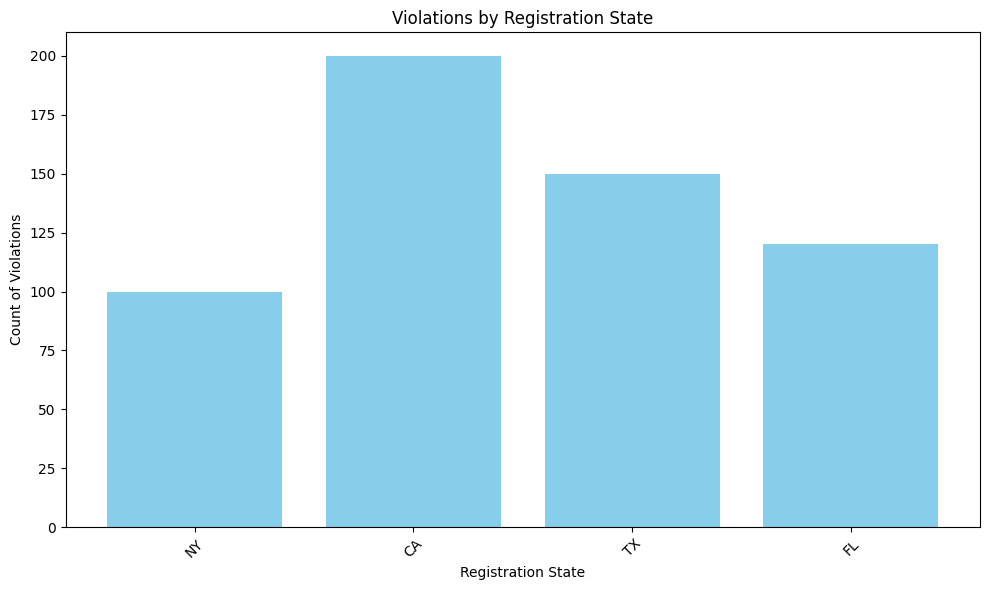

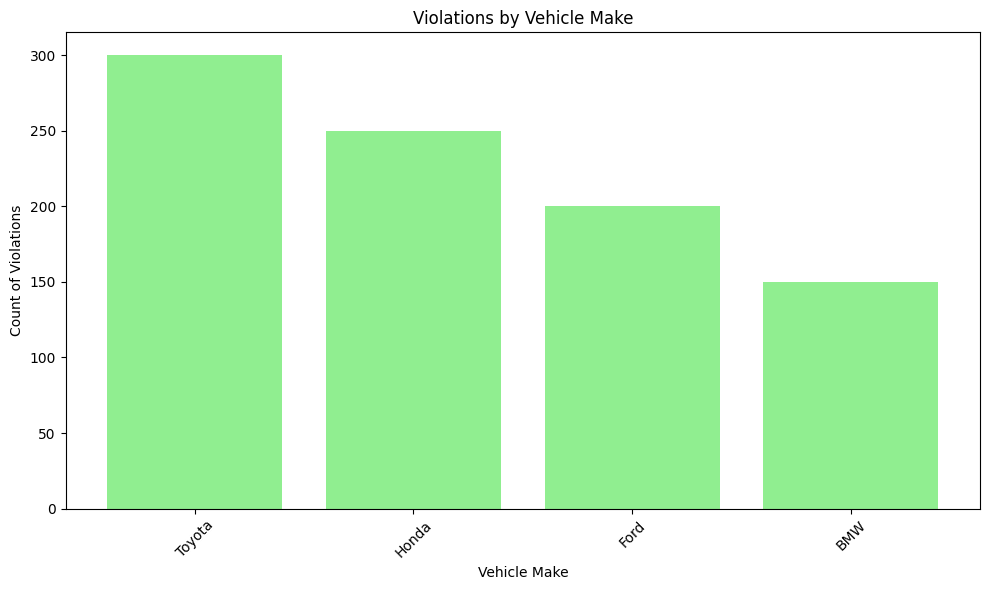

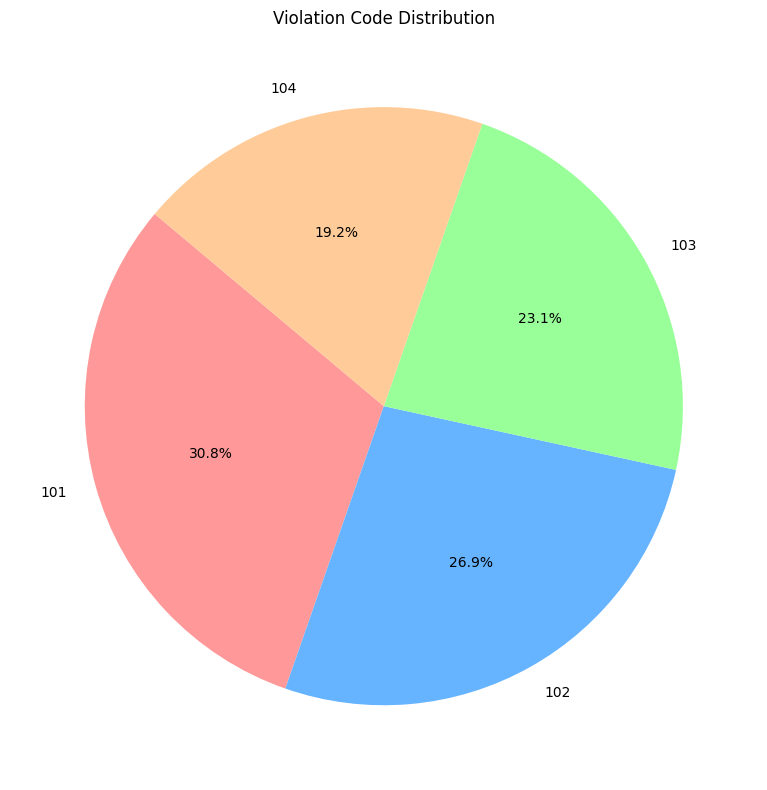

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Example aggregated data (assuming these are already available)
agg_by_state = pd.DataFrame({
    'registration_state': ['NY', 'CA', 'TX', 'FL'],
    'count': [100, 200, 150, 120]
})

agg_by_make = pd.DataFrame({
    'vehicle_make': ['Toyota', 'Honda', 'Ford', 'BMW'],
    'count': [300, 250, 200, 150]
})

agg_by_violation = pd.DataFrame({
    'violation_code': [101, 102, 103, 104],
    'count': [400, 350, 300, 250]
})

# 1. Bar Chart for Aggregated Data by Registration State
def plot_registration_state(agg_by_state):
    plt.figure(figsize=(10, 6))
    plt.bar(agg_by_state['registration_state'], agg_by_state['count'], color='skyblue')
    plt.xlabel('Registration State')
    plt.ylabel('Count of Violations')
    plt.title('Violations by Registration State')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 2. Bar Chart for Aggregated Data by Vehicle Make
def plot_vehicle_make(agg_by_make):
    plt.figure(figsize=(10, 6))
    plt.bar(agg_by_make['vehicle_make'], agg_by_make['count'], color='lightgreen')
    plt.xlabel('Vehicle Make')
    plt.ylabel('Count of Violations')
    plt.title('Violations by Vehicle Make')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3. Pie Chart for Aggregated Data by Violation Code
def plot_violation_code(agg_by_violation):
    plt.figure(figsize=(8, 8))
    plt.pie(agg_by_violation['count'], labels=agg_by_violation['violation_code'], autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b3ff','#99ff99','#ffcc99'])
    plt.title('Violation Code Distribution')
    plt.tight_layout()
    plt.show()

# Calling the functions to generate the plots
plot_registration_state(agg_by_state)
plot_vehicle_make(agg_by_make)
plot_violation_code(agg_by_violation)


In [ ]:
# Testing the Aggregation Function
!pip install pytest


In [ ]:
import unittest
import pandas as pd

class TestAggregation(unittest.TestCase):

    def setUp(self):
        """Set up a basic DataFrame for testing."""
        # Sample data to simulate your cleaned DataFrame
        self.df = pd.DataFrame({
            'registration_state': ['NY', 'CA', 'NY', 'TX', 'CA'],
            'vehicle_make': ['Toyota', 'Honda', 'Toyota', 'Ford', 'Honda'],
            'violation_code': [101, 102, 101, 103, 102]
        })

    def test_aggregation_by_registration_state(self):
        """Test if aggregation by registration state works correctly."""
        agg_by_state = self.df.groupby('registration_state').size().reset_index(name='Count')
        self.assertEqual(agg_by_state.shape[0], 3)  # Expect 3 unique registration states
        self.assertTrue('registration_state' in agg_by_state.columns)  # Check if column exists
        self.assertTrue('Count' in agg_by_state.columns)  # Check if count column exists

    def test_aggregation_by_vehicle_make(self):
        """Test if aggregation by vehicle make works correctly."""
        agg_by_make = self.df.groupby('vehicle_make').size().reset_index(name='Count')
        self.assertEqual(agg_by_make.shape[0], 3)  # Expect 3 unique vehicle makes
        self.assertTrue('vehicle_make' in agg_by_make.columns)  # Check if column exists
        self.assertTrue('Count' in agg_by_make.columns)  # Check if count column exists

    def test_aggregation_by_violation_code(self):
        """Test if aggregation by violation code works correctly."""
        agg_by_violation = self.df.groupby('violation_code').size().reset_index(name='Count')
        self.assertEqual(agg_by_violation.shape[0], 3)  # Expect 3 unique violation codes
        self.assertTrue('violation_code' in agg_by_violation.columns)  # Check if column exists
        self.assertTrue('Count' in agg_by_violation.columns)  # Check if count column exists

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)


...
----------------------------------------------------------------------
Ran 3 tests in 0.026s

OK


In [ ]:
!pytest


======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0
rootdir: /content
plugins: typeguard-4.4.1, anyio-3.7.1
collected 0 items                                                                                  

====================================== no tests ran in 0.01s =======================================


...

Buffer size before: 0


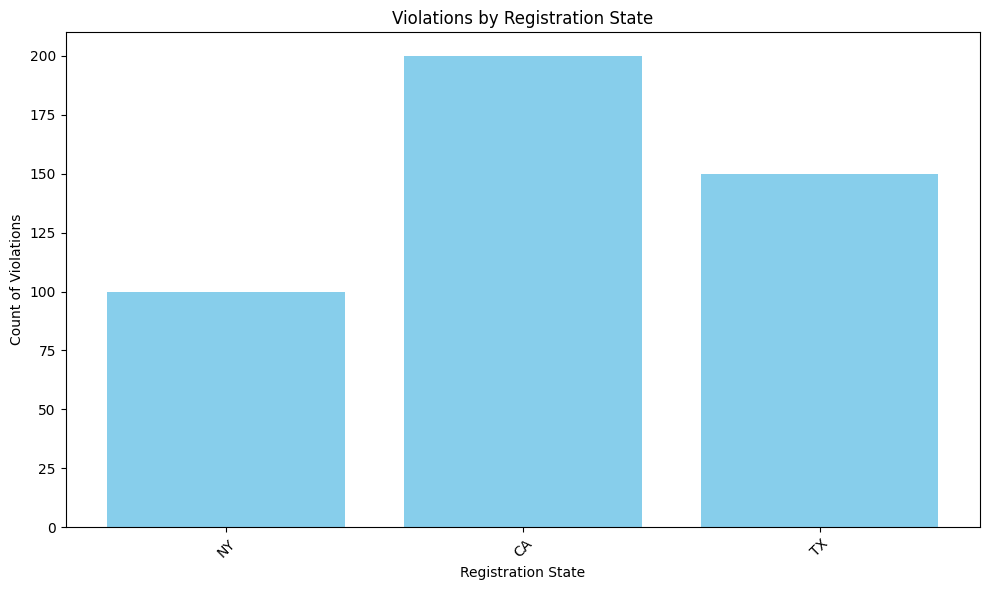

F

Buffer size after: 0


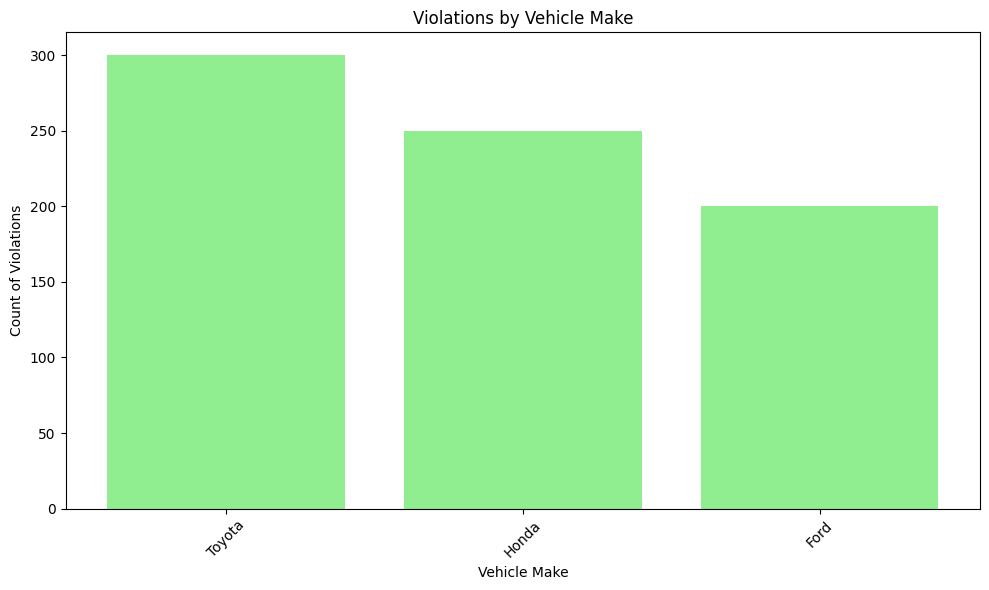

F

Buffer size before: 0


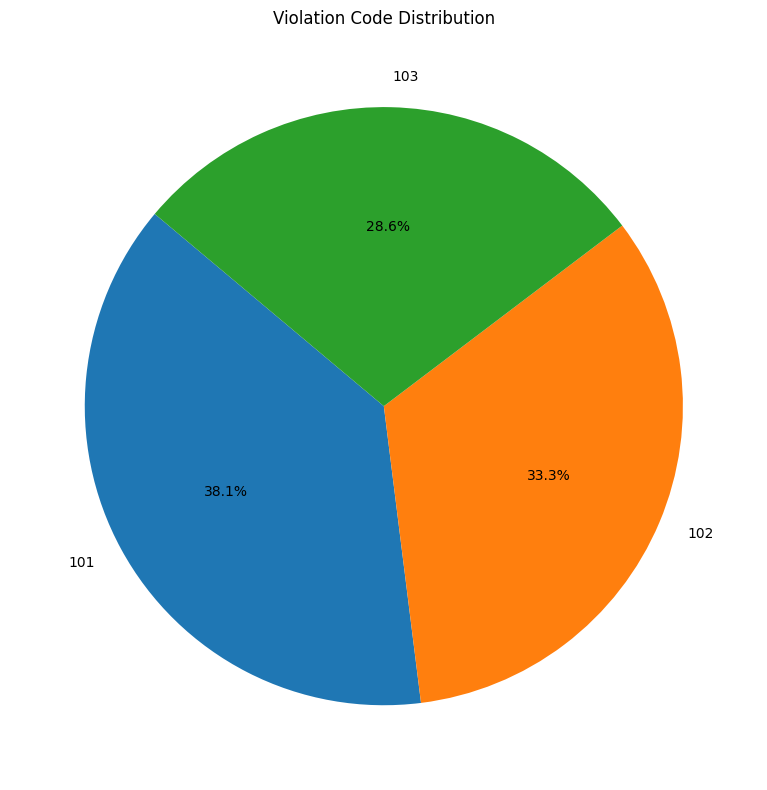

F
FAIL: test_plot_registration_state (__main__.TestVisualizations)
Test if the Registration State bar plot runs without errors.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-51-b2519745af1b>", line 50, in test_plot_registration_state
    self.assertTrue(buf.tell() > 0)  # Check if the plot was saved
AssertionError: False is not true

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "<ipython-input-51-b2519745af1b>", line 52, in test_plot_registration_state
    self.fail(f"Plotting failed with error: {e}")
AssertionError: Plotting failed with error: False is not true

FAIL: test_plot_vehicle_make (__main__.TestVisualizations)
Test if the Vehicle Make bar plot runs without errors.
----------------------------------------------------------------------
Traceback (most recent call last):
  File "<ipython-input-51-b2519745af1b>", line 74, in test_pl

Buffer size before: 0


In [ ]:
import unittest
import matplotlib.pyplot as plt
from io import BytesIO
import pandas as pd

class TestVisualizations(unittest.TestCase):

    def setUp(self):
        """Setup data for visualizations."""
        self.agg_by_state = pd.DataFrame({
            'registration_state': ['NY', 'CA', 'TX'],
            'count': [100, 200, 150]
        })

        self.agg_by_make = pd.DataFrame({
            'vehicle_make': ['Toyota', 'Honda', 'Ford'],
            'count': [300, 250, 200]
        })

        self.agg_by_violation = pd.DataFrame({
            'violation_code': [101, 102, 103],
            'count': [400, 350, 300]
        })

    def test_plot_registration_state(self):
        """Test if the Registration State bar plot runs without errors."""
        try:
            plt.figure(figsize=(10, 6))
            plt.bar(self.agg_by_state['registration_state'], self.agg_by_state['count'], color='skyblue')
            plt.xlabel('Registration State')
            plt.ylabel('Count of Violations')
            plt.title('Violations by Registration State')
            plt.xticks(rotation=45)
            plt.tight_layout()

            # Create a BytesIO buffer to save the plot
            buf = BytesIO()

            # Render the plot and save it to buffer
            plt.savefig(buf)  # Save to buffer
            buf.seek(0)  # Move the pointer to the start of the buffer

            # Debug: Check the size of the buffer before and after saving
            print(f"Buffer size before: {buf.tell()}")

            plt.show()  # Render the plot
            plt.close()  # Close the plot after saving
            print(f"Buffer size after: {buf.tell()}")  # Check if buffer has data

            self.assertTrue(buf.tell() > 0)  # Check if the plot was saved
        except Exception as e:
            self.fail(f"Plotting failed with error: {e}")

    def test_plot_vehicle_make(self):
        """Test if the Vehicle Make bar plot runs without errors."""
        try:
            plt.figure(figsize=(10, 6))
            plt.bar(self.agg_by_make['vehicle_make'], self.agg_by_make['count'], color='lightgreen')
            plt.xlabel('Vehicle Make')
            plt.ylabel('Count of Violations')
            plt.title('Violations by Vehicle Make')
            plt.xticks(rotation=45)
            plt.tight_layout()

            buf = BytesIO()
            plt.savefig(buf)  # Save to buffer
            buf.seek(0)
            plt.show()  # Render the plot
            plt.close()  # Close the plot after saving

            # Check the buffer size
            print(f"Buffer size before: {buf.tell()}")

            self.assertTrue(buf.tell() > 0)  # Check if the plot was saved
        except Exception as e:
            self.fail(f"Plotting failed with error: {e}")

    def test_plot_violation_code(self):
        """Test if the Violation Code pie chart runs without errors."""
        try:
            plt.figure(figsize=(8, 8))
            plt.pie(self.agg_by_violation['count'], labels=self.agg_by_violation['violation_code'], autopct='%1.1f%%', startangle=140)
            plt.title('Violation Code Distribution')
            plt.tight_layout()

            buf = BytesIO()
            plt.savefig(buf)  # Save to buffer
            buf.seek(0)
            plt.show()  # Render the plot
            plt.close()  # Close the plot after saving

            # Check the buffer size
            print(f"Buffer size before: {buf.tell()}")

            self.assertTrue(buf.tell() > 0)  # Check if the plot was saved
        except Exception as e:
            self.fail(f"Plotting failed with error: {e}")

if __name__ == '__main__':
    unittest.main(argv=[''], exit=False)
